In [165]:
import pandas as pd
import numpy as np
import itertools
import random
import math
from collections import defaultdict
from collections import Counter
from scipy.spatial.distance import euclidean

In [166]:
df = pd.read_csv('covid_cleaning_2501_2v.csv')
df = df[['municipioCaso', 'sexoCaso', 'idadeCaso', 'resultadoFinalExame']]
df = df.dropna()
df

C:\Users\Malu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5,6,7,8,9,15,20,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,50,51,52,53,54,55,56,58,59,60,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,municipioCaso,sexoCaso,idadeCaso,resultadoFinalExame
0,SOBRAL,MASCULINO,17.0,Negativo
1,PACAJUS,MASCULINO,37.0,Negativo
2,FORTALEZA,MASCULINO,28.0,Negativo
3,CAUCAIA,MASCULINO,50.0,Negativo
4,FORTALEZA,FEMININO,81.0,Negativo
...,...,...,...,...
855798,FORTALEZA,MASCULINO,33.0,Negativo
855799,SOBRAL,FEMININO,34.0,Negativo
855800,COREAU,MASCULINO,83.0,Negativo
855801,SOBRAL,FEMININO,41.0,Negativo


In [167]:
#df = df.iloc[:1000]

In [168]:
ordem = {
    ('municipioCaso', 'SOBRAL', 3, 330): len(df.query('municipioCaso == "SOBRAL"')),#('municipioCaso', 'SOBRAL', 10, 330): len(df.query('municipioCaso == "SOBRAL"')),
    ('idadeCaso', 25.0, 3, 560): len(df.query('idadeCaso == 25.0'))#('idadeCaso', 25.0, 10, 560): len(df.query('idadeCaso == 25.0'))
}
constraints = sorted(ordem, key = ordem.get)

In [169]:
def combinations_attr(dataset):
    qi_attr = list(dataset.columns[:-1])
    comb = []
    for i in range(len(qi_attr), 0, -1):
        comb.append(list(itertools.combinations(qi_attr, i)))
    comb = list(itertools.chain.from_iterable(comb))
    comb = list(map(list, comb))
    return comb

In [170]:
def include_in_nearest_cluster(tup, groups, dataset): #dataset anonimizado = new dataset
    min_distance = math.inf
    for key, value in zip(groups.keys(), groups.values()):
        if(len(tup[:-1].compare(dataset[dataset.columns[:-1]].loc[value[0][0]])) < min_distance):
            min_distance = len(tup[:-1].compare(dataset[dataset.columns[:-1]].loc[value[0][0]]))
            nearest_cluster = list(itertools.chain.from_iterable(groups[key]))
    
    for value in nearest_cluster:
        for attr in (tup[:-1].compare(dataset[dataset.columns[:-1]].loc[value])).index:
            if(tup[attr] != dataset[attr].loc[value]):
                tup[attr] = '*'
                dataset[attr].loc[value] = '*'
                dataset.loc[tup.name] = tup
    
    return dataset        

In [171]:
def placeholding(diff_attr, new_df, value):
    if(len(diff_attr) == 0):
        return new_df
    
    for diff in diff_attr:
        new_df[diff].loc[value] = "*"
    
    return new_df

In [172]:
def anonymize(dataset, k, constraints):
    new_df = pd.DataFrame(columns = dataset.columns)
    clusters = defaultdict(list)
    
    #grouping by constraints
    for constraint in constraints:
        grouped = False
        
        if(type(constraint[1]) == (float or int)):
            c = dataset.query('{} == {}'.format(constraint[0],constraint[1]))
        else:
            c = dataset.query('{} == "{}"'.format(constraint[0],constraint[1]))

        for comb in combinations_attr(c):
            group = c.groupby(comb).groups
            if(grouped):
                break
            
            for key,v in zip(group.keys(), group.values()):
                if(grouped):
                    c[constraint[0]] = c[constraint[0]].replace({'{}'.format(constraint[1]):'*'})
                    dataset[constraint[0]] = dataset[constraint[0]].replace({'{}'.format(constraint[1]):'*'})
                    break

                aux = max(k, constraint[2])
                if(len(v.values) >= aux and len(v.values) <= constraint[3]):
                    #clusters[key].append(v.values.tolist())
                    for j in range(len(v.values)):
                        new_df.loc[v.values[j]] = list(c.loc[v.values[j]])
                        dataset = dataset.drop(v.values[j])
                        c = c.drop(v.values[j])
                        diff_attr = list(dataset.columns[:-1].symmetric_difference(comb))
                        new_df = placeholding(diff_attr, new_df, v.values[j])
                        grouped = True
            

    #grouping remaining tuples
    for comb in combinations_attr(dataset):
        group = dataset.groupby(comb).groups
        for key,v in zip(group.keys(), group.values()):
            if(len(v.values) >= k):
                clusters[key].append(v.values.tolist())
                for j in range(len(v.values)):
                    new_df.loc[v.values[j]] = list(dataset.loc[v.values[j]])
                    dataset = dataset.drop(v.values[j])
                    diff_attr = list(dataset.columns[:-1].symmetric_difference(comb))
                    new_df = placeholding(diff_attr, new_df, v.values[j])

    if(len(dataset) != 0):
        for i in range(len(dataset)):
            include_in_nearest_cluster(dataset.iloc[i], clusters, new_df)

    return new_df

In [173]:
#df_anon = anonymize(df, 4, constraints)
#df_anon = df_anon.sort_index(axis=0)

In [174]:
#df_anon

In [175]:
def l_diversity(dataset, l, label): 
    count_labels = Counter(dataset[label])
    ec_values = list(dataset.groupby(list(dataset.columns[:-1])).count().index)

    #para que a idade seja no mesmo formato que "*", vamos transformá-la em string
    dataset['idadeCaso'] = dataset['idadeCaso'].astype(str)

    for values in ec_values:
        equivalence_class = dataset.query('municipioCaso == "{}" & sexoCaso  == "{}" & idadeCaso == "{}"'.format(values[0], values[1], values[2]))

        if(len(np.unique(equivalence_class[label])) < l):
            while(len(np.unique(equivalence_class[label])) < l):
                new_labels = random.choices(list(count_labels.keys()), weights=count_labels.values(), k=len(equivalence_class))
                equivalence_class[label] = new_labels
        for i in equivalence_class.index:
            dataset[label].loc[i] = equivalence_class[label].loc[i]
    return dataset

In [176]:
#df_anon = l_diversity(df_anon, 3, 'resultadoFinalExame')

In [177]:
#df_anon

In [178]:
def accuracy(dataset, dataset_anon):
    dataset['idadeCaso'] = dataset['idadeCaso'].astype(str)
    comp = (dataset == dataset_anon)
    aux_accuracy = comp.describe()

    equal_values = 0
    
    #count True values to divide it per number of cells
    for col in comp.columns:
        if(aux_accuracy[col].loc['top'] == True):
            equal_values += aux_accuracy[col].loc['freq']
        else:
            equal_values += aux_accuracy[col].loc['count'] - aux_accuracy[col].loc['freq'] #if false, we have to get the complementar

    return equal_values/(len(dataset.columns)*len(dataset))

# Evaluating approach

In [186]:
import warnings
warnings.filterwarnings('ignore')

In [187]:
n_tuples = [5000, 10000, 15000, 20000, 25000]
k_values = [5, 10, 15, 25, 30]

acc = []

for t in n_tuples:
    ac_k = []
    for k in k_values:
        df_anon = anonymize(df[:t], k, constraints) #k-anonymity
        df_anon = df_anon.sort_index(axis=0)        #k-anonymity  
        df_anon = l_diversity(df_anon, 3, 'resultadoFinalExame') #l-diversity
        ac = accuracy(df[:t], df_anon)
        ac_k.append(ac)
    print("\n number of tuples: {}\n k: {}\n accuracy: {}\n".format(t, k_values, ac_k))
    acc.append(ac_k)


 number of tuples: 5000
 k: [5, 10, 15, 25, 30]
 accuracy: [0.7271, 0.70055, 0.67645, 0.65625, 0.64485]


 number of tuples: 10000
 k: [5, 10, 15, 25, 30]
 accuracy: [0.7279, 0.708075, 0.6942, 0.68265, 0.68]


 number of tuples: 15000
 k: [5, 10, 15, 25, 30]
 accuracy: [0.7422, 0.7161, 0.7038666666666666, 0.6949833333333333, 0.6880333333333334]


 number of tuples: 20000
 k: [5, 10, 15, 25, 30]
 accuracy: [0.7527, 0.723825, 0.7126125, 0.7001625, 0.695475]


 number of tuples: 25000
 k: [5, 10, 15, 25, 30]
 accuracy: [0.76522, 0.73248, 0.71875, 0.70708, 0.70224]



In [197]:
acc

[[0.7271, 0.70055, 0.67645, 0.65625, 0.64485],
 [0.7279, 0.708075, 0.6942, 0.68265, 0.68],
 [0.7422, 0.7161, 0.7038666666666666, 0.6949833333333333, 0.6880333333333334],
 [0.7527, 0.723825, 0.7126125, 0.7001625, 0.695475],
 [0.76522, 0.73248, 0.71875, 0.70708, 0.70224]]

In [198]:
acc = np.array(acc).transpose()

# Graphics

In [200]:
import matplotlib.pyplot as plt

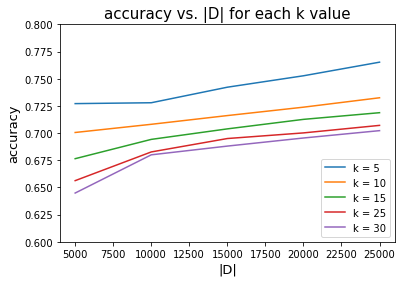

In [222]:
x = n_tuples

y0 = acc[0]
y1 = acc[1]
y2 = acc[2]
y3 = acc[3]
y4 = acc[4]

plt.plot(x, y0, label='k = {}'.format(k_values[0]))
plt.plot(x, y1, label="k = {}".format(k_values[1]))
plt.plot(x, y2, label="k = {}".format(k_values[2]))
plt.plot(x, y3, label="k = {}".format(k_values[3]))
plt.plot(x, y4, label="k = {}".format(k_values[4]))
plt.ylim(ymax=.8, ymin=.6)

plt.title('accuracy vs. |D| for each k value',fontsize=15)
plt.xlabel('|D|', fontsize=13)
plt.ylabel('accuracy', fontsize=13)
plt.legend()
plt.savefig('accuracy.png',format='png', dpi=320)
plt.show()

In [223]:
n_tuples = [60000, 120000, 180000, 240000, 300000]
k_values = [10, 20, 30, 40, 50]

acc = []

for t in n_tuples:
    ac_k = []
    for k in k_values:
        df_anon = anonymize(df[:t], k, constraints) #k-anonymity
        df_anon = df_anon.sort_index(axis=0)        #k-anonymity  
        df_anon = l_diversity(df_anon, 3, 'resultadoFinalExame') #l-diversity
        ac = accuracy(df[:t], df_anon)
        ac_k.append(ac)
    print("\n number of tuples: {}\n k: {}\n accuracy: {}\n".format(t, k_values, ac_k))
    acc.append(ac_k)


 number of tuples: 60000
 k: [10, 20, 30, 40, 50]
 accuracy: [0.7792541666666667, 0.7441958333333333, 0.7312083333333333, 0.7243375, 0.7183833333333334]


 number of tuples: 120000
 k: [10, 20, 30, 40, 50]
 accuracy: [0.8215270833333334, 0.77750625, 0.7576458333333334, 0.7471375, 0.7410104166666667]


 number of tuples: 180000
 k: [10, 20, 30, 40, 50]
 accuracy: [0.8547958333333333, 0.8130361111111111, 0.7885333333333333, 0.7773416666666667, 0.7657680555555556]


 number of tuples: 240000
 k: [10, 20, 30, 40, 50]
 accuracy: [0.88159375, 0.8424697916666667, 0.8192375, 0.8037677083333333, 0.79388125]


 number of tuples: 300000
 k: [10, 20, 30, 40, 50]
 accuracy: [0.8983866666666667, 0.8627775, 0.8400566666666667, 0.8230241666666667, 0.8125783333333333]



In [229]:
acc.transpose()

array([[0.77925417, 0.82152708, 0.85479583, 0.88159375, 0.89838667],
       [0.74419583, 0.77750625, 0.81303611, 0.84246979, 0.8627775 ],
       [0.73120833, 0.75764583, 0.78853333, 0.8192375 , 0.84005667],
       [0.7243375 , 0.7471375 , 0.77734167, 0.80376771, 0.82302417],
       [0.71838333, 0.74101042, 0.76576806, 0.79388125, 0.81257833]])

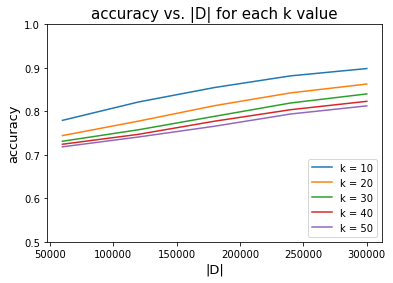

In [240]:
from matplotlib.font_manager import FontProperties

acc = np.array(acc).transpose()

x = n_tuples

y0 = acc[0]
y1 = acc[1]
y2 = acc[2]
y3 = acc[3]
y4 = acc[4]

plt.plot(x, y0, label='k = {}'.format(k_values[0]))
plt.plot(x, y1, label="k = {}".format(k_values[1]))
plt.plot(x, y2, label="k = {}".format(k_values[2]))
plt.plot(x, y3, label="k = {}".format(k_values[3]))
plt.plot(x, y4, label="k = {}".format(k_values[4]))
plt.ylim(ymax=1, ymin=.5)

plt.title('accuracy vs. |D| for each k value',fontsize=15)
plt.xlabel('|D|', fontsize=13)
plt.ylabel('accuracy', fontsize=13)

plt.legend(loc=4)
plt.savefig('accuracy.png',format='png', dpi=320)
plt.show()

# Evaluating approach: varying len(constraints) and k

In [ ]:
warnings.filterwarnings('ignore')

df_ = df.iloc[:5000]
ordem = {
    ('municipioCaso', 'SOBRAL', 3, 147): len(df_.query('municipioCaso == "SOBRAL"')), #50
    ('idadeCaso', 25.0, 3, 123): len(df_.query('idadeCaso == 25.0')), 
    ('municipioCaso', 'CAUCAIA', 3, 98): len(df_.query('municipioCaso == "CAUCAIA"')),
    ('sexoCaso', 'FEMININO', 3, 5321): len(df_.query('sexoCaso == "FEMININO"'))
}
constraints = sorted(ordem, key = ordem.get)

n_constraints = [2, 3, 4]
k_values = [2, 4, 6, 8, 10]

accuracy_fixed_D = []

for c in n_constraints:
    ac_c = []
    for k in k_values:
        df_anon_c = anonymize(df_, k, constraints[:c])
        df_anon_c = df_anon_c.sort_index(axis=0)
        df_anon_c = l_diversity(df_anon_c, 2, 'resultadoFinalExame')
        a = accuracy(df_, df_anon_c)
        print("\t - c = {}, k={}, ac = {}\n".format(c, k, a))
        ac_c.append(a)
    print("number of constraints: {}\n k: {}\n accuracy: {}\n\n".format(c, k, ac_c))
    accuracy_fixed_D.append(ac_c)

	 - c = 2, k=2, ac = 0.8583

	 - c = 2, k=4, ac = 0.8101



In [ ]:
accuracy_fixed_D = np.array(accuracy_fixed_D).transpose()
x = k_values

y0 = accuracy_fixed_D[0]
y1 = accuracy_fixed_D[1]
y2 = accuracy_fixed_D[2]

plt.plot(x, y0, label='|Σ| = {}'.format(n_constraints[0]))
plt.plot(x, y1, label="|Σ| = {}".format(n_constraints[1]))
plt.plot(x, y2, label="|Σ| = {}".format(n_constraints[2]))
plt.ylim(ymax=1, ymin=.5)

plt.title('accuracy vs. k for each |Σ| size',fontsize=15)
plt.xlabel('k', fontsize=13)
plt.ylabel('accuracy', fontsize=13)
plt.legend(loc=4)
plt.savefig('accuracy_constraints.png',format='png', dpi=320)
plt.show()